In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PEAD = pd.read_csv('PEAD.csv')
market = pd.read_csv('market.csv')
PEAD = pd.merge(PEAD,market, on = 'DATE')
PEAD['DATE'] = pd.to_datetime(PEAD.DATE,format = "%Y%m%d")

In [6]:
event_idx = PEAD[PEAD['ann'] == 1].index
stdized_excess_returns = []
for idx in event_idx:
    permno = PEAD['PERMNO'][idx]
    event_date = PEAD['DATE'][idx]
    excess = PEAD['RET'][idx] - PEAD['ret_m'][idx]

    data = PEAD[PEAD['PERMNO'] == permno]
    data = data.reset_index(drop = True)
    new_idx = data[data['DATE'] == event_date].index[0]

    window_start = event_date - pd.to_timedelta('60 days')
    window_start_idx = data[data['DATE']>=window_start].index[0]
    window = data[window_start_idx:new_idx+1]

    sigma = window['RET'].std()
    stdized_excess = excess / sigma
    stdized_excess_returns.append(stdized_excess)

stdized_excess_returns = np.array(stdized_excess_returns)

In [7]:
k = 3

most_positive_idx = event_idx[np.where(stdized_excess_returns>=k)[0]]
most_negative_idx = event_idx[np.where(stdized_excess_returns<=-k)[0]]

most_positive_avrg_30 = []
most_negative_avrg_30 = []

most_positive_raw = []
most_negative_raw = []

for idx in most_positive_idx:
    if PEAD['ann'][idx] != 1: raise RuntimeError('FUCK YOU')
    permno = PEAD['PERMNO'][idx]
    event_date = PEAD['DATE'][idx]
    data = PEAD[PEAD['PERMNO'] == permno]
    data = data.reset_index(drop = True)
    new_idx = data[data['DATE'] == event_date].index[0]

    if data['ann'][new_idx] != 1: raise RuntimeError('MOTHERFUCKER')
    window_end = event_date + pd.to_timedelta('30 days')
    window_end_idx = data[data['DATE'] <= window_end].index[-1]
    window = data[new_idx:window_end_idx+1]
    avrg_return = window['RET'].mean()
    most_positive_raw.append(window['RET'])
    most_positive_avrg_30.append(avrg_return)

for idx in most_negative_idx:
    if PEAD['ann'][idx] != 1: raise RuntimeError('FUCK YOU')
    permno = PEAD['PERMNO'][idx]
    event_date = PEAD['DATE'][idx]
    data = PEAD[PEAD['PERMNO'] == permno]
    data = data.reset_index(drop = True)
    new_idx = data[data['DATE'] == event_date].index[0]

    if data['ann'][new_idx] != 1: raise RuntimeError('MOTHERFUCKER')
    window_end = event_date + pd.to_timedelta('30 days')
    window_end_idx = data[data['DATE'] <= window_end].index[-1]
    window = data[new_idx:window_end_idx+1]
    avrg_return = window['RET'].mean()
    most_negative_raw.append(window['RET'])
    most_negative_avrg_30.append(avrg_return)


In [13]:
most_negative_avrg_30 = np.array(most_negative_avrg_30)
most_positive_avrg_30 = np.array(most_positive_avrg_30)

all_returns = np.append(most_negative_avrg_30, most_positive_avrg_30)

all_mean = all_returns.mean()
pos_mean = most_positive_avrg_30.mean()
neg_mean = most_negative_avrg_30.mean()
pos_l = len(most_positive_avrg_30)
neg_l = len(most_negative_avrg_30)

SST = np.square(all_returns - all_mean).sum()
SSG = (pos_mean - all_mean)**2 * pos_l + (neg_mean - all_mean)**2 * neg_l
SSE = SST - SSG

dfT = pos_l + neg_l
dfG = 2 - 1 
dfE = dfT - dfG

MSG = SSG/dfG
MSE = SSE/dfE

f = MSG/MSE

from scipy import stats

1 - stats.f.cdf(f,pos_l+neg_l, 1)

0.014328514908458212

In [64]:
all_sum = 0
num_obs = 0
for series in most_positive_raw:
    all_sum += series.sum()
    num_obs += len(series)
all_mean = all_sum / num_obs
SST = 0
SSG = 0
i= 0
for series in most_positive_raw:
    series = series.fillna(0)
    SST += np.square(np.array(series - all_mean)).sum()
    SSG += (series.mean() - all_mean)**2 * len(series)

SSE = SST-SSG
dfT = num_obs
dfG = len(most_negative_raw) - 1
dfE = dfT - dfG

MSG = SSG/dfG
MSE = SSE/dfE

f = MSG/MSE

from scipy import stats

1 - stats.f.cdf(f,pos_l+neg_l, 1)

0.8208258627894587

In [65]:
all_sum = 0
num_obs = 0
for series in most_negative_raw + most_positive_raw:
    all_sum += series.sum()
    num_obs += len(series)
all_mean = all_sum / num_obs
SST = 0
SSG = 0
i= 0
for series in most_negative_raw + most_positive_raw:
    series = series.fillna(0)
    SST += np.square(np.array(series - all_mean)).sum()
    SSG += (series.mean() - all_mean)**2 * len(series)

SSE = SST-SSG
dfT = num_obs
dfG = len(most_negative_raw) + len(most_positive_raw) - 1
dfE = dfT - dfG

MSG = SSG/dfG
MSE = SSE/dfE

f = MSG/MSE

from scipy import stats
1 - stats.f.cdf(f,pos_l+neg_l, 1)

0.6924550889047858

(b)

In [128]:
def backtest(n):
    performance = dict()
    #initialize dictionary
    for date in pd.to_datetime(PEAD['DATE'].unique()):
        performance[date] = []


    for idx in most_positive_idx:
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.reset_index(drop = True)
        data = data.fillna(0)
        new_idx = data[data['DATE'] == event_date].index[0] 

        pos_close_date = event_date + pd.to_timedelta(str(n) + ' days')
        pos_close_idx = data[data['DATE'] <= pos_close_date].index[-1]

        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to fund
            date_diff = pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day")
            total_return = (1 + data['RET'][idx]) * np.exp(-date_diff/360 * 0.03)#penalize for funding
            performance[date].append(total_return)

    for idx in most_negative_idx:
        if PEAD['ann'][idx] != 1: raise RuntimeError('FUCK YOU')        
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.fillna(0)
        data = data.reset_index(drop = True)
        new_idx = data[data['DATE'] == event_date].index[0] 
        if data['ann'][new_idx] != 1: raise RuntimeError('MOTHERFUCKER')

        pos_close_date = event_date + pd.to_timedelta(str(n) + ' days')
        pos_close_idx = data[data['DATE'] <= pos_close_date].index[-1]

        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to earn interest
            date_diff = pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day")
            total_return = (1 - data['RET'][idx]) * np.exp(date_diff/360 * 0.01)
            performance[date].append(total_return)


    returns = pd.DataFrame(pd.to_datetime(PEAD['DATE'].unique()),columns = ['Date'])
    returns = returns.set_index('Date',drop = True)
    returns['Ret'] = 1

    for date in performance:
        return_arr = np.array(performance[date])
        if len(return_arr) > 0:
            returns.loc[date,'Ret'] = return_arr.mean()

    return returns['Ret']

In [129]:
def backtest_by_trading_day(n):
    performance = dict()
    #initialize dictionary
    for date in pd.to_datetime(PEAD['DATE'].unique()):
        performance[date] = []


    for idx in most_positive_idx:
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.reset_index(drop = True)
        new_idx = data[data['DATE'] == event_date].index[0]    
        pos_close_idx = min(new_idx + n, len(data)-1)
        data = data.fillna(0)

        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to fund
            date_diff = pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day")
            total_return = (1 + data['RET'][idx]) * np.exp(-date_diff/360 * 0.03)#penalize for funding
            performance[date].append(total_return)

    for idx in most_negative_idx:    
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.reset_index(drop = True)
        data = data.fillna(0)
        new_idx = data[data['DATE'] == event_date].index[0]
        pos_close_idx = min(new_idx + n, len(data)-1)
        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to earn interest
            date_diff = pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day")
            total_return = (1 - data['RET'][idx]) * np.exp(date_diff/360 * 0.01)
            performance[date].append(total_return)


    returns = pd.DataFrame(pd.to_datetime(PEAD['DATE'].unique()),columns = ['Date'])
    returns = returns.set_index('Date',drop = True)
    returns['Ret'] = 1

    for date in performance:
        return_arr = np.array(performance[date])
        if len(return_arr) > 0:
            returns.loc[date,'Ret'] = return_arr.mean()

    return returns['Ret']

In [132]:
def AR(n):
    performance = dict()
    for i in range(1,n+1):
        performance[i] = []

    for idx in most_positive_idx:
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]  
        data = data.reset_index(drop = True)
        new_idx = data[data['DATE'] == event_date].index[0] 
        data = data.fillna(0)

        pos_close_date = event_date + pd.to_timedelta(str(n) + ' days')
        pos_close_idx = data[data['DATE'] <= pos_close_date].index[-1]


        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to fund
            date_diff = int(pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day"))  
            total_return = (1 + data['RET'][idx]) * np.exp(-date_diff/360 * 0.03)#penalize for funding
            date_event_diff = int(pd.to_timedelta(date - event_date)/ pd.to_timedelta("1 day")) 
            performance[date_event_diff].append(total_return)


    for idx in most_negative_idx:       
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement

        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.reset_index(drop = True)
        data = data.fillna(0)
        new_idx = data[data['DATE'] == event_date].index[0] 

        pos_close_date = event_date + pd.to_timedelta(str(n) + ' days')
        pos_close_idx = data[data['DATE'] <= pos_close_date].index[-1]

        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to earn interest
            date_diff = int(pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day"))
            total_return = (1 - data['RET'][idx]) * np.exp(date_diff/360 * 0.01)
            date_event_diff = int(pd.to_timedelta(date - event_date)/ pd.to_timedelta("1 day")) 
            performance[date_event_diff].append(total_return)

    returns = dict()

    for date in performance:
        return_arr = np.array(performance[date])
        returns[date] = return_arr.mean()
    return returns


In [131]:
def AR_by_trading_day(n):
    performance = dict()
    for i in range(1,n+1):
        performance[i] = []

    for idx in most_positive_idx:
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement
        
        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.fillna(0)
        data = data.reset_index(drop = True)
        new_idx = data[data['DATE'] == event_date].index[0] 
        pos_close_idx = min(new_idx + n, len(data)-1)

        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to fund
            date_diff = int(pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day"))  
            total_return = (1 + data['RET'][idx]) * np.exp(-date_diff/360 * 0.03)#penalize for funding
            performance[idx - new_idx].append(total_return)


    for idx in most_negative_idx:       
        permno = PEAD['PERMNO'][idx]
        event_date = PEAD['DATE'][idx] #date after the announcement
        data = PEAD[PEAD['PERMNO'] == permno]
        data = data.reset_index(drop = True)
        data = data.fillna(0)
        new_idx = data[data['DATE'] == event_date].index[0] 
        pos_close_idx = min(new_idx + n, len(data)-1)

        for idx in range(new_idx+1,pos_close_idx+1):
            date = data['DATE'][idx]
            #number of days to earn interest
            date_diff = int(pd.to_timedelta(data['DATE'][idx] - data['DATE'][idx-1]) / pd.to_timedelta("1 day"))
            total_return = (1 - data['RET'][idx]) * np.exp(date_diff/360 * 0.01)
            performance[idx - new_idx].append(total_return)

    returns = dict()

    for date in performance:
        return_arr = np.array(performance[date])
        returns[date] = return_arr.mean()
    return returns

In [139]:
AR_5 = AR(5)
AR_10 = AR(10)
AR_20 = AR(20)
AR_30 = AR(30)


In [133]:
AR_5_by_trading_day = AR_by_trading_day(5)
AR_10_by_trading_day = AR_by_trading_day(10)
AR_20_by_trading_day = AR_by_trading_day(20)
AR_30_by_trading_day = AR_by_trading_day(30)


1
4095
2
4094
3
4094
4
4093
5
4093
1
4095
2
4094
3
4094
4
4093
5
4093
6
4090
7
4088
8
4084
9
4083
10
4083
1
4095
2
4094
3
4094
4
4093
5
4093
6
4090
7
4088
8
4084
9
4083
10
4083
11
4081
12
4081
13
4080
14
4079
15
4079
16
4074
17
4074
18
4074
19
4074
20
4074
1
4095
2
4094
3
4094
4
4093
5
4093
6
4090
7
4088
8
4084
9
4083
10
4083
11
4081
12
4081
13
4080
14
4079
15
4079
16
4074
17
4074
18
4074
19
4074
20
4074
21
4074
22
4074
23
4072
24
4069
25
4069
26
4068
27
4066
28
4066
29
4063
30
4061


In [140]:
# fund value plot
ret_5 = backtest(5)
ret_10 = backtest(10)
ret_20 = backtest(20)
ret_30 = backtest(30)

value_5 = ret_5.cumprod()
value_10 = ret_10.cumprod()
value_20 = ret_20.cumprod()
value_30 = ret_30.cumprod()

In [141]:
ret_5_by_trading_day = backtest_by_trading_day(5)
ret_10_by_trading_day = backtest_by_trading_day(10)
ret_20_by_trading_day = backtest_by_trading_day(20)
ret_30_by_trading_day = backtest_by_trading_day(30)

value_5_by_trading_day = ret_5_by_trading_day.cumprod()
value_10_by_trading_day = ret_10_by_trading_day.cumprod()
value_20_by_trading_day = ret_20_by_trading_day.cumprod()
value_30_by_trading_day = ret_30_by_trading_day.cumprod()

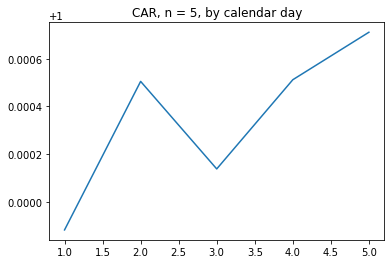

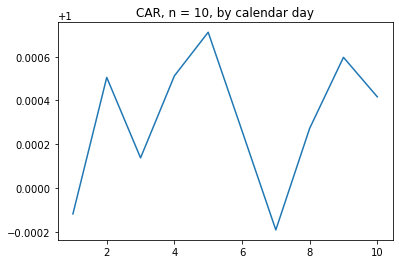

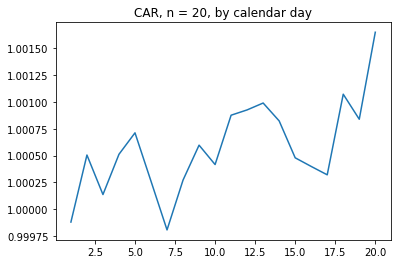

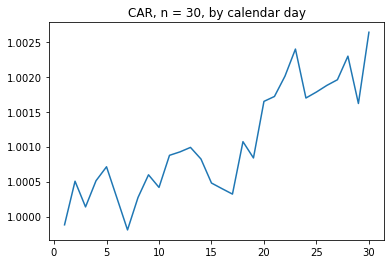

In [155]:
pd.Series(AR_5).cumprod().plot()
plt.title("CAR, n = 5, by calendar day")
plt.show()

pd.Series(AR_10).cumprod().plot()
plt.title("CAR, n = 10, by calendar day")
plt.show()

pd.Series(AR_20).cumprod().plot()
plt.title("CAR, n = 20, by calendar day")
plt.show()

pd.Series(AR_30).cumprod().plot()
plt.title("CAR, n = 30, by calendar day")
plt.show()

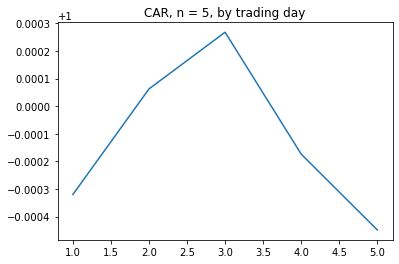

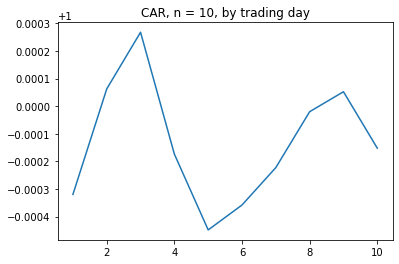

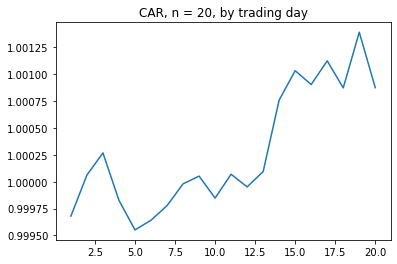

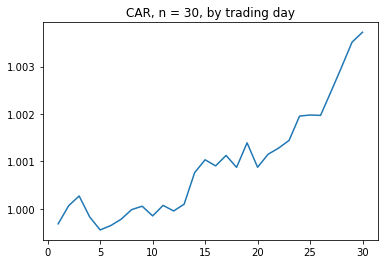

In [157]:
pd.Series(AR_5_by_trading_day).cumprod().plot()
plt.title("CAR, n = 5, by trading day")
plt.show()

pd.Series(AR_10_by_trading_day).cumprod().plot()
plt.title("CAR, n = 10, by trading day")
plt.show()

pd.Series(AR_20_by_trading_day).cumprod().plot()
plt.title("CAR, n = 20, by trading day")
plt.show()

pd.Series(AR_30_by_trading_day).cumprod().plot()
plt.title("CAR, n = 30, by trading day")
plt.show()

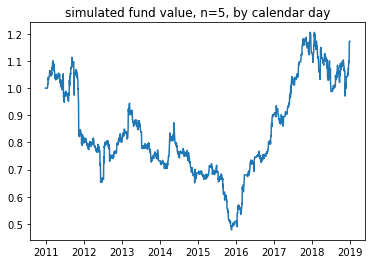

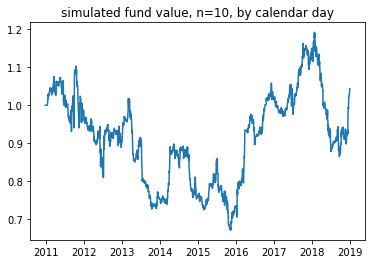

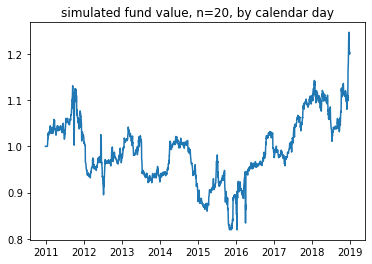

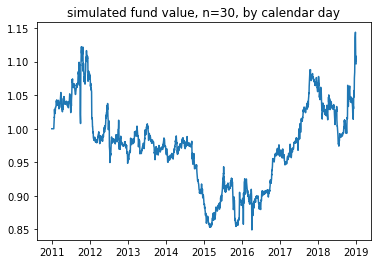

In [159]:
plt.plot(value_5)
plt.title("simulated fund value, n=5, by calendar day")
plt.show()


plt.plot(value_10)
plt.title("simulated fund value, n=10, by calendar day")
plt.show()


plt.plot(value_20)
plt.title("simulated fund value, n=20, by calendar day")
plt.show()


plt.plot(value_30)
plt.title("simulated fund value, n=30, by calendar day")
plt.show()


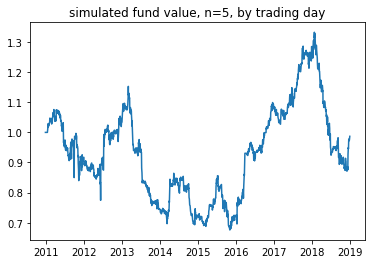

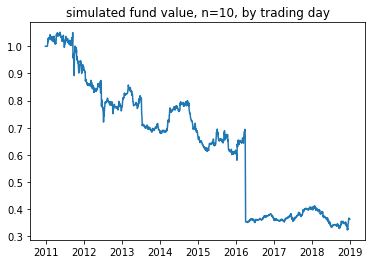

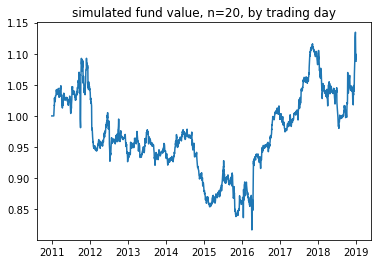

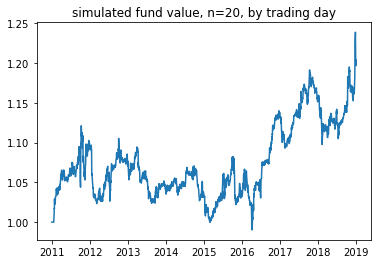

In [158]:
plt.plot(value_5_by_trading_day)
plt.title("simulated fund value, n=5, by trading day")
plt.show()


plt.plot(value_10_by_trading_day)
plt.title("simulated fund value, n=10, by trading day")
plt.show()


plt.plot(value_20_by_trading_day)
plt.title("simulated fund value, n=20, by trading day")
plt.show()


plt.plot(value_30_by_trading_day)
plt.title("simulated fund value, n=20, by trading day")
plt.show()

In [1]:
ret_10_by_trading_day[ret_10_by_trading_day<=-0.5]

NameError: name 'ret_10_by_trading_day' is not defined

In [118]:
print(value_5[-1])
print(value_5_by_trading_day[-1])

1.1727260978854712
1.1727260978854712


In [161]:
FF_factors = pd.read_csv("F-F_Research_Data_Factors_daily.csv", skiprows=4)[20000:-1]
FF_factors.columns = ["Date", 'Mkt-RF', 'SMB', 'HML', 'RF']
FF_factors['Date'] = pd.to_datetime(FF_factors['Date'],format = '%Y%m%d')

In [162]:
FF_5 = pd.merge(FF_factors,ret_5 - 1,on = 'Date')
FF_10 = pd.merge(FF_factors,ret_10 - 1,on = 'Date')
FF_20 = pd.merge(FF_factors,ret_20 - 1,on = 'Date')
FF_30 = pd.merge(FF_factors,ret_30 - 1,on = 'Date')

In [163]:
import statsmodels.api as sm
for FF in [FF_5,FF_10,FF_20,FF_30]:
    FF = FF.fillna(0)
    Y = FF['Ret'] - FF['RF']
    X = sm.add_constant(FF[['Mkt-RF','SMB','HML']])/100
    print(sm.OLS(Y,X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.947
Date:                Mon, 12 Apr 2021   Prob (F-statistic):              0.120
Time:                        23:49:07   Log-Likelihood:                 6005.2
No. Observations:                2013   AIC:                        -1.200e+04
Df Residuals:                    2009   BIC:                        -1.198e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1290      0.027     -4.713      0.0

In [164]:
FF_5_by_trading_day = pd.merge(FF_factors,ret_5_by_trading_day - 1,on = 'Date')
FF_10_by_trading_day = pd.merge(FF_factors,ret_10_by_trading_day - 1,on = 'Date')
FF_20_by_trading_day = pd.merge(FF_factors,ret_20_by_trading_day - 1,on = 'Date')
FF_30_by_trading_day= pd.merge(FF_factors,ret_30_by_trading_day - 1,on = 'Date')

for FF in [FF_5_by_trading_day,FF_10_by_trading_day,FF_20_by_trading_day,FF_30_by_trading_day]:
    FF = FF.fillna(0)
    Y = FF['Ret'] - FF['RF']
    X = sm.add_constant(FF[['Mkt-RF','SMB','HML']])/100
    print(sm.OLS(Y,X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.817
Date:                Mon, 12 Apr 2021   Prob (F-statistic):             0.0378
Time:                        23:49:14   Log-Likelihood:                 6222.9
No. Observations:                2013   AIC:                        -1.244e+04
Df Residuals:                    2009   BIC:                        -1.242e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1389      0.025     -5.653      0.0

In [69]:
#FF_30[FF_30.isna().any(axis=1)]

,Date,Mkt-RF,SMB,HML,RF,Ret
222,2011-11-16,-1.64,-0.15,-0.18,0.0,NaN
481,2012-11-29,0.54,0.68,-0.01,0.0,NaN
